In [158]:
import numpy as np
import matplotlib.pyplot as plt


class LevenbergMarquardt:

    """
    Finds the least-squares solution for a nonlinear function using the
    Levenberg-Marquart (LM) algorithm.
    """

    def __init__(
            self,
            func=None,
            grad=None,
            tol=1e-3,
            lambda_=1,
            alpha=1,
            max_iter=1000,
            plot_conv=False,
    ):
        """
        Initializes the LevenbergMarquardt optimization class object.

        Args:
            func: the function to which we are fitting the least squares solution
            grad: gradient of the function, if provided by the user
            tol: how close to zero that the gradient vector has to be for convergence
            lambda_: dampening factor used in the LM to replace the omitted term in the
                Gauss-Newton formula
            alpha: step size when updating x_k to x_k + 1
            max_iter: max number of iterations allowed before the algorithm terminates
            plot_sol:
            plot_conv: set to True if MSE and parameter values per iteration should
                be plotted
        """

        # Store input parameters as class attributes
        self.func = func
        self.gradient = grad
        self.tol = tol
        self.lambda_ = lambda_
        self.alpha = alpha
        self.max_iter = max_iter
        self.plot_conv = plot_conv

        # Variables for storing results in optimization
        self.function_values = []
        self.param_values = []
        self.final_gradient = None
        self.final_diff = None
        self.final_fx = None
        self.final_x_k = None

        # Attribute for tracking succesful convergence
        self.success = False
        self.n_iterations = 0

    def calculate_function(self, x_k):
        """
        Calculate the mean squared error (MSE) for the y values of the given data
        points and the function value for the current parameter values.
        """

        # Call supplied function to calculate f(x) for each data point
        fx = self.func(x_k)

        # Calculate MSE: (1 / n) * (y - y_hat)^2
        mse = (fx @ fx.T) / len(fx)

        return fx, mse

    def calculate_gradient(self, fx, x_k):
        """
        Calculates the gradient numerically given a numpy array of function values.
        """

        if self.gradient:  # Call function supplied by user if it exists
            grad_fx = self.gradient(x_k)
        else:  # Otherwise, use numerical gradient approximation
            grad = np.gradient(fx)
            grad_fx = np.stack((grad, grad))

        return grad_fx

    def run_lm_algorithm(self, x0):
        """
        Finds the least-squares solution for a nonlinear function using the
        Levenberg-Marquart (LM) algorithm.

        Args:
            x0: starting guess for parameter values

        Returns:
            x_k: optimal parameter values
            function_values: value of the function for each iteration
            parameter_values value of parameters for each iteration
        """

        # Initial values for parameters
        x_k = np.array(x0)

        # Dampening factor
        damp = self.lambda_ * np.eye(len(x_k))

        # Initialize flag and count variables
        self.n_iterations = 0

        # Loop until optimum or other stopping criteria reached
        while self.n_iterations < self.max_iter:
            self.n_iterations += 1

            # Save parameter values for this iteration
            self.param_values.append(x_k)

            # Compute F(x) vectors and gradient matrix of F(x)
            fx, mse = self.calculate_function(x_k)
            self.function_values.append(mse)
            grad_fx = self.calculate_gradient(fx, x_k)
            fx = fx.reshape(-1, 1)

            # Compute next point x_k+1
            x_k = x_k - self.alpha * (np.linalg.inv(grad_fx @ grad_fx.T + damp)) @ \
                  (grad_fx @ fx)

            if np.sum(np.abs(grad_fx @ fx)) <= self.tol:
                self.success = True
                break

        # Calculate final vectors and values at termination, for output
        self.final_gradient = grad_fx @ fx
        self.final_x_k = x_k
        self.final_fx = fx
        
    def minimize(self, x_k):
        self.run_lm_algorithm(x_k)
        self.print_output_report()
        
        if self.plot_conv:
            self.plot_convergence()
            
        return self.final_x_k, self.function_values[-1], self.final_fx
    
    def print_output_report(self):
        """Prints results of the optimization in digestable format"""

        # Print results
        print("------ Output report ------\n")
        print(f"Successful convergence: {self.success}")
        print(f"Parameter values: {self.final_x_k}")
        print(f"Function value: {self.function_values[-1]}")
        print(f"Number of iterations: {self.n_iterations}")
        print(f"Final gradient vector: {self.final_gradient}")
        
    def plot_convergence(self):
        """
        Plot function value and parameter values for each iteration, to analyze
        convergence behavior of the algorithm.
        """
        # TODO: Add plot for x_k

        # Create plot
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        plt.suptitle("Convergence behavior", fontsize=14)

        # Plot MSE 
        axes[0].plot(range(len(self.function_values)), self.function_values, color="blue")
        axes[0].set_title("Mean squared error (function value)", fontsize=12)
        axes[0].set_xlabel("iteration", fontsize=12)
        axes[0].set_ylabel("Mean squared error (MSE)", fontsize=12)

        # Plot parameter values
        
        if len(self.param_values[0]) > 1:
            x_1 = [x_k[0] for x_k in self.param_values]
            x_2 = [x_k[1] for x_k in self.param_values]
            axes[1].scatter(x_1, x_2)
            axes[1].set_xlabel("x_1", fontsize=12)
            axes[1].set_ylabel("x_2", fontsize=12)
        else:
            x_1 = [x_k for x_k in self.param_values]
            axes[1].scatter(x_1)
            axes[1].set_xlabel("x_1", fontsize=12)
            axes[1].set_ylabel("", fontsize=12)
        
        axes[1].set_title("Parameter values (max two shown)", fontsize=12)
        
        plt.show()

    def plot_solution(self, x_values, y_values):
        """
        Plot the solution given by the optimized parameters and the original
        datapoints.
        """

        # Create plot
        plt.figure(figsize=(6, 4))
        plt.title("Least squares solution", fontsize=14, pad=16)
        plt.xlabel("x", fontsize=12)
        plt.ylabel("f(x)", fontsize=12)

        # Calculate least squares solution (line)
        line_range = np.arange(min(x_values), max(x_values) + 0.1, 0.1)
        line_values = [self.final_x_k[0] * np.exp(self.final_x_k[1] * line_range[i]) for i in range(len(line_range))]

        # Plot solution and original datapoints
        plt.scatter(x_values, y_values, color="red")
        plt.plot(line_range, line_values, color="blue")
        plt.show()


In [142]:
def main_1():

    # TEST CASE 1 (given in the assignment)

    print("Running Test case 1 (given in assignment)\n")
    print("Function is: y(t) = x_1 * e^(x_2 * t)\n")

    # Define values of t, y_t and x0
    t = np.arange(0.5, 4.5, 0.5)
    y_t = np.array([7.2, 3.0, 1.5, 0.85, 0.48, 0.25, 0.20, 0.15])
    x0 = [1, 1]

    # Define test function
    def test_function_1(x_k):
        
        y = y_t
        x = t
        fx = y - (x_k[0] * np.exp(x_k[1] * x))
        
        return fx

    # Define gradient function
    def test_gradient_1(x_k):
        
        x = t
        grad_fx = np.array([-np.exp(x_k[1] * x), -x * x_k[0] * np.exp(x_k[1] * x)])
        
        return grad_fx

    # Initialize optimizer WITH gradient argument
    optimizer_1 = LevenbergMarquardt(
        func=test_function_1,
        grad=test_gradient_1,
        tol=1e-3,
        lambda_=1,
        alpha=1,
        max_iter=1000,
        plot_conv=True,
    )

    # Run optimizer
    optimizer_1.minimize(x0)
    optimizer_1.plot_solution(t, y_t)
    
    # Initialize optimizer WITHOUT gradient argument
    #optimizer_2 = LevenbergMarquardt(
        #func=test_function_1,
        #tol=1e-3,
        #lambda_=1,
        #alpha=1,
        #max_iter=1000,
        #plot_conv=True,
    #)

    # Run optimizer
    #optimizer_2.minimize(x0)
    #optimizer_2.plot_solution(t, y_t)

Running Test case 1 (given in assignment)

Function is: y(t) = x_1 * e^(x_2 * t)

------ Output report ------

Successful convergence: True
Parameter values: [15.61545656 -1.57109094]
Function value: 0.021621240306341584
Number of iterations: 135
Final gradient vector: [-0.00087709  0.00011445]


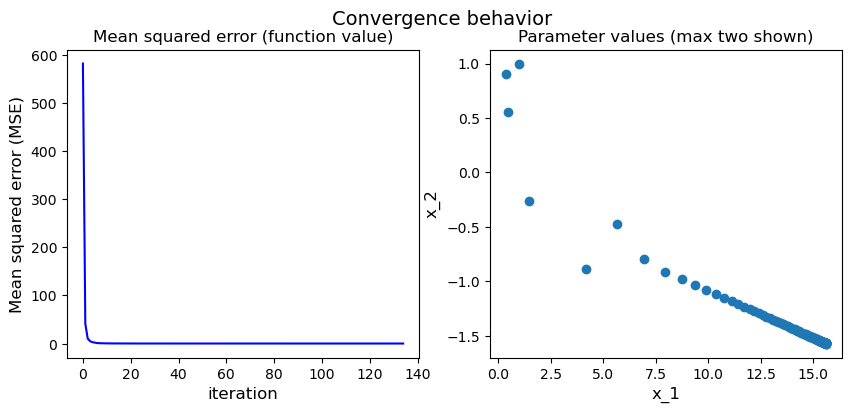

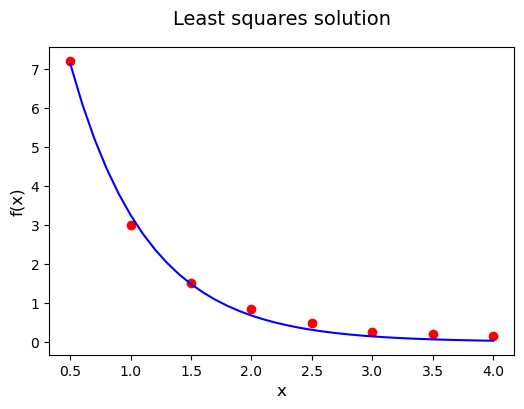

In [143]:
main_1()

In [176]:
def main_2():

    # TEST CASE 1 (given in the assignment)

    print("Running Test case 2\n")
    print("Function is: f(t) = x_1*t + x_2*t^2 - x_3*t^3\n")

    # Define values of t, y_t and x0
    x_true = [1, 1.5, -2]
    y_calc = lambda t: x_true[0] * t + np.power(x_true[1] * t, 2) - np.power(x_true[2] * t, 3)   
    t = np.arange(0, 10, 1)
    y_t = np.array([y_calc(t_val) for t_val in t]) + np.random.normal(loc=0, scale=1, size=(1, len(t)))
    x0 = [1, 1, 1]

    # Define test function
    def test_function_2(x_k):
        
        y = y_t
        x = t
        fx = y - ((x_k[0] * t) + (np.power(x_k[1] * t, 2)) - (np.power(x_k[2] * t, 3)))
        
        return fx

    # Define gradient function
    def test_gradient_2(x_k):
        
        x = t
        grad_fx = np.array([-x, -2 * t, 3 * t])
        
        return grad_fx

    # Initialize optimizer WITH gradient argument
    optimizer_2 = LevenbergMarquardt(
        func=test_function_2,
        grad=test_gradient_2,
        tol=1e-3,
        lambda_=1,
        alpha=1,
        max_iter=1000,
        plot_conv=True,
    )

    # Run optimizer
    optimizer_2.minimize(x0)
    optimizer_2.plot_solution(t, y_t)

In [177]:
main_2()

Running Test case 2

Function is: f(t) = x_1*t + x_2*t^2 - x_3*t^3



ValueError: operands could not be broadcast together with shapes (3,) (10,) 

In [147]:
x_true = [1, 1.5, -2]
y_calc = lambda t: (x_true[0] * t) + (x_true[1] * t ** 2) - (x_true[2] * t ** 3)   
t = np.arange(0, 10, 1)
y_t = np.array([y_calc(t_val) for t_val in t]) + np.random.normal(loc=0, scale=1, size=(1, len(t)))
x0 = [1, 1, 1]

def test_function_2(x_k):
        
    y = y_t
    x = t
    fx = y - (x_k[0] * t + x_k[1] * t^2 - x_k[2] * t^3)  
        
    return fx.reshape(-1, 1)

In [156]:
# Define gradient function
def test_gradient_2(x_k):
        
    x = t
    grad_fx = np.array([-x, -2 * t, 3 * t])
        
    return grad_fx

In [149]:
test_function_2(x0)

array([[-6.96876640e-01],
       [ 5.28765750e+00],
       [ 1.64898870e+01],
       [ 7.76828554e+01],
       [ 1.65794942e+02],
       [ 3.04455901e+02],
       [ 5.04584120e+02],
       [ 7.76656114e+02],
       [ 1.15068569e+03],
       [ 1.61169706e+03]])

In [157]:
test_gradient_2(x0)

array([[  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9],
       [  0,  -2,  -4,  -6,  -8, -10, -12, -14, -16, -18],
       [  0,   3,   6,   9,  12,  15,  18,  21,  24,  27]])

In [160]:
test_gradient_2(x0) @ test_function_2(x0) 

array([[-34631.63190457],
       [-69263.26380914],
       [103894.89571372]])

In [161]:
# Define values of t, y_t and x0
t = np.arange(0.5, 4.5, 0.5)
y_t = np.array([7.2, 3.0, 1.5, 0.85, 0.48, 0.25, 0.20, 0.15])
x0 = [1, 1]

# Define test function
def test_function_1(x_k):
        
    y = y_t
    x = t
    fx = y - (x_k[0] * np.exp(x_k[1] * x))
        
    return fx

# Define gradient function
def test_gradient_1(x_k):
        
    x = t
    grad_fx = np.array([-np.exp(x_k[1] * x), -x * x_k[0] * np.exp(x_k[1] * x)])
        
    return grad_fx.reshape(-1, 1)

In [162]:
test_function_1(x0).shape

(8,)

In [163]:
test_gradient_2(x0).shape

(3, 8)

In [164]:
test_gradient_2(x0) @ test_function_1(x0)

array([  436.25281593,   872.50563185, -1308.75844778])

In [55]:
t = np.arange(0.5, 4.5, 0.5)
y_t = np.array([7.2, 3.0, 1.5, 0.85, 0.48, 0.25, 0.20, 0.15])
x0 = [1, 1]

# Define test function
def test_function_1(x_k):
        
    y = y_t
    x = t
    fx = y - x_k[0] * np.exp(x_k[1] * x)
        
    return fx

In [56]:
fx = test_function_1(x0)
fx

array([  5.55127873,   0.28171817,  -2.98168907,  -6.5390561 ,
       -11.70249396, -19.83553692, -32.91545196, -54.44815003])

In [57]:
grad = np.gradient(fx)
grad_fx = np.stack((grad, grad))
grad_fx

array([[ -5.26956056,  -4.2664839 ,  -3.41038714,  -4.36040245,
         -6.64824041, -10.606479  , -17.30630655, -21.53269807],
       [ -5.26956056,  -4.2664839 ,  -3.41038714,  -4.36040245,
         -6.64824041, -10.606479  , -17.30630655, -21.53269807]])

In [58]:
def test_gradient_1(x_k):
        
    x = t
    grad_fx = np.array([-np.exp(x_k[1] * x), -x * x_k[0] * np.exp(x_k[1] * x)])
        
    return grad_fx

In [59]:
test_gradient_1(x0)

array([[  -1.64872127,   -2.71828183,   -4.48168907,   -7.3890561 ,
         -12.18249396,  -20.08553692,  -33.11545196,  -54.59815003],
       [  -0.82436064,   -2.71828183,   -6.72253361,  -14.7781122 ,
         -30.4562349 ,  -60.25661077, -115.90408186, -218.39260013]])